Был выбран датасет с текстом рэп песен. По тексту угадывание исполнителя. Датасет сам не очень большой


--- Базовый бейзлайн ---

Точность базовой модели: 0.3302

Отчет по классификации (базовый бейзлайн):
                 precision    recall  f1-score   support

          2Pac       0.43      0.27      0.33        11
          Dave       0.13      0.60      0.21         5
         Drake       0.24      0.54      0.33        13
        Eminem       0.54      0.81      0.65        16
        Future       1.00      0.11      0.20         9
       J. Cole       0.50      0.20      0.29        15
Kendrick Lamar       0.75      0.60      0.67         5
           Nas       0.00      0.00      0.00        11
   Nicki Minaj       0.00      0.00      0.00         6
       Rapsody       0.18      0.33      0.24         6
        Skepta       0.00      0.00      0.00         9

      accuracy                           0.33       106
     macro avg       0.34      0.32      0.27       106
  weighted avg       0.36      0.33      0.29       106


--- Улучшенный бейзлайн ---



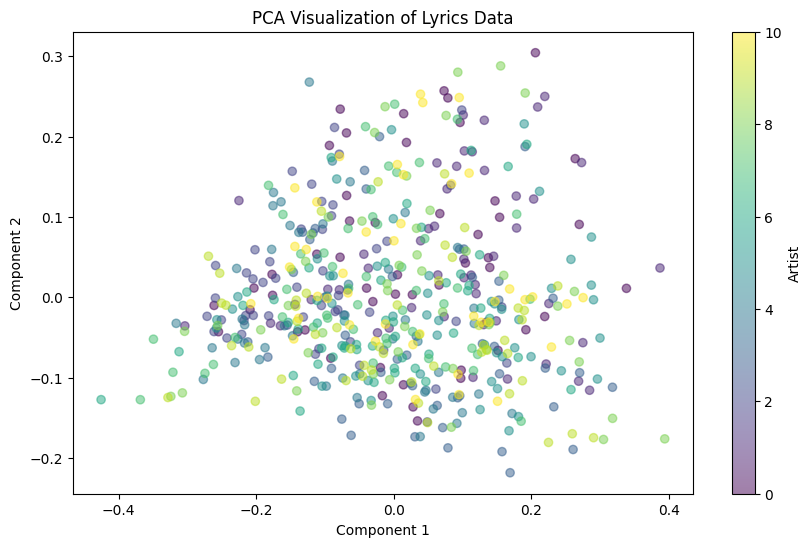

Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 10}

Точность улучшенной модели: 0.4057

Отчет по классификации (улучшенный бейзлайн):
                 precision    recall  f1-score   support

          2Pac       0.60      0.27      0.38        11
          Dave       0.18      0.80      0.30         5
         Drake       0.37      0.54      0.44        13
        Eminem       0.50      0.88      0.64        16
        Future       0.00      0.00      0.00         9
       J. Cole       1.00      0.13      0.24        15
Kendrick Lamar       0.75      0.60      0.67         5
           Nas       0.50      0.64      0.56        11
   Nicki Minaj       0.00      0.00      0.00         6
       Rapsody       0.27      0.50      0.35         6
        Skepta       0.00      0.00      0.00         9

      accuracy                           0.41       106
     macro avg       0.38      0.40      0.32       106
  weighted avg       0.44      0.41      0.35       106

Матрица ошибок:

In [7]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


data_path = '/content/lyrics_raw.csv'
data = pd.read_csv(data_path)

# Предобработка текста
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Применяем предобработку к столбцу с текстами песен
data['processed_lyrics'] = data['raw_lyrics'].apply(preprocess_text)

# Извлечение признаков и меток (исполнитель)
X = data['processed_lyrics']
y = data['artist']

### Базовый бейзлайн ###
print("\n--- Базовый бейзлайн ---\n")
# Преобразование текста в признаки с использованием TF-IDF (без n-грамм)
tfidf_vectorizer_base = TfidfVectorizer(max_features=5000)
X_tfidf_base = tfidf_vectorizer_base.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_tfidf_base, y, test_size=0.2, random_state=42)

# Простая модель KNN
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train_base, y_train_base)

# Оценка базовой модели
y_pred_base = knn_base.predict(X_test_base)
accuracy_base = accuracy_score(y_test_base, y_pred_base)
report_base = classification_report(y_test_base, y_pred_base)
print(f"Точность базовой модели: {accuracy_base:.4f}\n")
print("Отчет по классификации (базовый бейзлайн):\n", report_base)

### Улучшенный бейзлайн ###
print("\n--- Улучшенный бейзлайн ---\n")
# Преобразование текста в признаки с использованием TF-IDF (n-граммы)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Снижение размерности для визуализации (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0], cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Lyrics Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Artist')
plt.show()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Подбор гиперпараметров для KNN с использованием GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'metric': ['cosine', 'euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Лучшая модель KNN
best_knn = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}\n")

# Обучение и оценка улучшенной модели
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Точность улучшенной модели: {accuracy:.4f}\n")
print("Отчет по классификации (улучшенный бейзлайн):\n", report)
print("Матрица ошибок:\n", conf_matrix)

# Сравнение результатов
print("\n--- Сравнение моделей ---\n")
print(f"Точность базовой модели: {accuracy_base:.4f}")
print(f"Точность улучшенной модели: {accuracy:.4f}")


#логистическая и линейной регрессия


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import pandas as pd
import re

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

file_path = '/content/lyrics_raw.csv'
lyrics_data = pd.read_csv(file_path)

# Применение предобработки к текстам песен
lyrics_data['processed_lyrics'] = lyrics_data['raw_lyrics'].apply(preprocess_text)

# Преобразование текста в числовые признаки с использованием TF-IDF
# Ограничиваем количество признаков до 5000 для управления размерностью
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lyrics_data['processed_lyrics']).toarray()
y = lyrics_data['artist']

# Разделение данных на обучающую и тестовую выборки
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Логистическая регрессия для классификации
print("\n--- Логистическая регрессия ---\n")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_cls, y_train_cls)
y_pred_log_reg = log_reg.predict(X_test_cls)
accuracy_log_reg = accuracy_score(y_test_cls, y_pred_log_reg)
print(f"Точность: {accuracy_log_reg:.4f}")
print("Отчет по классификации:\n", classification_report(y_test_cls, y_pred_log_reg))

# Линейная регрессия для числового предсказания
# Создаем регрессионную задачу: предсказание длины текста на основе TF-IDF признаков
lyrics_data['text_length'] = lyrics_data['raw_lyrics'].apply(lambda x: len(x.split()))
y_reg = lyrics_data['text_length']

# Разделение данных для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

print("\n--- Линейная регрессия ---\n")
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
y_pred_lin_reg = lin_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_lin_reg)
print(f"Среднеквадратическая ошибка: {mse:.4f}")



--- Логистическая регрессия ---

Точность: 0.6415
Отчет по классификации:
                 precision    recall  f1-score   support

          2Pac       0.78      0.64      0.70        11
          Dave       0.42      1.00      0.59         5
         Drake       0.70      0.54      0.61        13
        Eminem       1.00      0.75      0.86        16
        Future       0.67      0.22      0.33         9
       J. Cole       1.00      0.27      0.42        15
Kendrick Lamar       0.56      1.00      0.71         5
           Nas       1.00      0.73      0.84        11
   Nicki Minaj       0.43      1.00      0.60         6
       Rapsody       0.36      0.83      0.50         6
        Skepta       0.64      0.78      0.70         9

      accuracy                           0.64       106
     macro avg       0.69      0.70      0.62       106
  weighted avg       0.76      0.64      0.64       106


--- Линейная регрессия ---

Среднеквадратическая ошибка: 2114762.3769


####Улучшение бейзлайна

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
import pandas as pd
import re


def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

file_path = '/content/lyrics_raw.csv'
lyrics_data = pd.read_csv(file_path)

# Применение предобработки к текстам песен
lyrics_data['processed_lyrics'] = lyrics_data['raw_lyrics'].apply(preprocess_text)

# Преобразование текста в числовые признаки с использованием TF-IDF
# Ограничиваем количество признаков до 5000 для управления размерностью
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Добавляем n-граммы для улучшения качества модели
X = tfidf.fit_transform(lyrics_data['processed_lyrics']).toarray()
y = lyrics_data['artist']

# Разделение данных на обучающую и тестовую выборки
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Логистическая регрессия для классификации с подбором гиперпараметров
print("\n--- Логистическая регрессия с улучшением ---\n")
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100]}  # Подбор гиперпараметра регуляризации
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
log_reg.fit(X_train_cls, y_train_cls)
print(f"Лучший параметр C: {log_reg.best_params_}")
y_pred_log_reg = log_reg.predict(X_test_cls)
accuracy_log_reg = accuracy_score(y_test_cls, y_pred_log_reg)
print(f"Точность: {accuracy_log_reg:.4f}")
print("Отчет по классификации:\n", classification_report(y_test_cls, y_pred_log_reg))

# Линейная регрессия для числового предсказания
# Создаем регрессионную задачу: предсказание длины текста на основе TF-IDF признаков
lyrics_data['text_length'] = lyrics_data['raw_lyrics'].apply(lambda x: len(x.split()))
y_reg = lyrics_data['text_length']

# Разделение данных для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

print("\n--- Линейная регрессия с улучшением ---\n")
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)
y_pred_lin_reg = lin_reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_lin_reg)
print(f"Среднеквадратическая ошибка: {mse:.4f}")



--- Логистическая регрессия с улучшением ---

Лучший параметр C: {'C': 100}
Точность: 0.7170
Отчет по классификации:
                 precision    recall  f1-score   support

          2Pac       0.77      0.91      0.83        11
          Dave       0.83      1.00      0.91         5
         Drake       0.67      0.62      0.64        13
        Eminem       1.00      0.88      0.93        16
        Future       0.33      0.22      0.27         9
       J. Cole       0.88      0.47      0.61        15
Kendrick Lamar       0.62      1.00      0.77         5
           Nas       1.00      0.64      0.78        11
   Nicki Minaj       0.50      1.00      0.67         6
       Rapsody       0.50      0.67      0.57         6
        Skepta       0.67      0.89      0.76         9

      accuracy                           0.72       106
     macro avg       0.71      0.75      0.70       106
  weighted avg       0.75      0.72      0.71       106


--- Линейная регрессия с улучшением -

#Решающее дерево

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import re

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

file_path = '/content/lyrics_raw.csv'
lyrics_data = pd.read_csv(file_path)

# Применение предобработки к текстам песен
lyrics_data['processed_lyrics'] = lyrics_data['raw_lyrics'].apply(preprocess_text)

# Преобразование текста в числовые признаки с использованием TF-IDF
# Ограничиваем количество признаков до 5000 для управления размерностью
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lyrics_data['processed_lyrics']).toarray()
y = lyrics_data['artist']

# Разделение данных на обучающую и тестовую выборки
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Решающее дерево
print("\n--- Решающее дерево ---\n")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_cls, y_train_cls)
y_pred_dt = dt_classifier.predict(X_test_cls)
accuracy_dt = accuracy_score(y_test_cls, y_pred_dt)
print(f"Точность: {accuracy_dt:.4f}")
print("Отчет по классификации:\n", classification_report(y_test_cls, y_pred_dt))

# Улучшение бейзлайна для решающего дерева
print("\n--- Улучшенное решающее дерево ---\n")
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_cls, y_train_cls)

# Лучшая модель решающего дерева
best_dt = grid_search_dt.best_estimator_
print(f"Лучшие параметры: {grid_search_dt.best_params_}")
y_pred_best_dt = best_dt.predict(X_test_cls)
accuracy_best_dt = accuracy_score(y_test_cls, y_pred_best_dt)
print(f"Точность улучшенной модели: {accuracy_best_dt:.4f}")
print("Отчет по классификации (улучшенное дерево):\n", classification_report(y_test_cls, y_pred_best_dt))



--- Решающее дерево ---

Точность: 0.8868
Отчет по классификации:
                 precision    recall  f1-score   support

          2Pac       0.91      0.91      0.91        11
          Dave       1.00      0.80      0.89         5
         Drake       0.87      1.00      0.93        13
        Eminem       0.82      0.88      0.85        16
        Future       1.00      0.44      0.62         9
       J. Cole       1.00      0.80      0.89        15
Kendrick Lamar       0.83      1.00      0.91         5
           Nas       0.92      1.00      0.96        11
   Nicki Minaj       1.00      1.00      1.00         6
       Rapsody       0.86      1.00      0.92         6
        Skepta       0.75      1.00      0.86         9

      accuracy                           0.89       106
     macro avg       0.91      0.89      0.88       106
  weighted avg       0.90      0.89      0.88       106


--- Улучшенное решающее дерево ---

Лучшие параметры: {'max_depth': 20, 'min_samples_lea

Некоторых артистов стало угадывать лучше, некоторых хуже, ну и в целом точность после улучшения почему-то снизилась

#Случайный лес

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import re

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

file_path = '/content/lyrics_raw.csv'
lyrics_data = pd.read_csv(file_path)

# Применение предобработки к текстам песен
lyrics_data['processed_lyrics'] = lyrics_data['raw_lyrics'].apply(preprocess_text)

# Преобразование текста в числовые признаки с использованием TF-IDF
# Ограничиваем количество признаков до 5000 для управления размерностью
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lyrics_data['processed_lyrics']).toarray()
y = lyrics_data['artist']

# Разделение данных на обучающую и тестовую выборки
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Случайный лес
print("\n--- Случайный лес ---\n")
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_cls, y_train_cls)
y_pred_rf = rf_classifier.predict(X_test_cls)
accuracy_rf = accuracy_score(y_test_cls, y_pred_rf)
print(f"Точность: {accuracy_rf:.4f}")
print("Отчет по классификации:\n", classification_report(y_test_cls, y_pred_rf))

# Улучшение бейзлайна для случайного леса
print("\n--- Улучшенный случайный лес ---\n")
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_cls, y_train_cls)

# Лучшая модель случайного леса
best_rf = grid_search_rf.best_estimator_
print(f"Лучшие параметры: {grid_search_rf.best_params_}")
y_pred_best_rf = best_rf.predict(X_test_cls)
accuracy_best_rf = accuracy_score(y_test_cls, y_pred_best_rf)
print(f"Точность улучшенной модели: {accuracy_best_rf:.4f}")
print("Отчет по классификации (улучшенный случайный лес):\n", classification_report(y_test_cls, y_pred_best_rf))



--- Случайный лес ---

Точность: 0.9151
Отчет по классификации:
                 precision    recall  f1-score   support

          2Pac       0.91      0.91      0.91        11
          Dave       1.00      1.00      1.00         5
         Drake       0.92      0.92      0.92        13
        Eminem       1.00      0.88      0.93        16
        Future       0.82      1.00      0.90         9
       J. Cole       1.00      0.73      0.85        15
Kendrick Lamar       0.83      1.00      0.91         5
           Nas       1.00      0.91      0.95        11
   Nicki Minaj       0.86      1.00      0.92         6
       Rapsody       0.86      1.00      0.92         6
        Skepta       0.82      1.00      0.90         9

      accuracy                           0.92       106
     macro avg       0.91      0.94      0.92       106
  weighted avg       0.93      0.92      0.91       106


--- Улучшенный случайный лес ---

Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 

В этот раз после улучшения стало лучше.

#Градиентный бустинг

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import re

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

file_path = '/content/lyrics_raw.csv'
lyrics_data = pd.read_csv(file_path)

# Применение предобработки к текстам песен
lyrics_data['processed_lyrics'] = lyrics_data['raw_lyrics'].apply(preprocess_text)

# Преобразование текста в числовые признаки с использованием TF-IDF
# Ограничиваем количество признаков до 5000 для управления размерностью
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lyrics_data['processed_lyrics']).toarray()
y = lyrics_data['artist']

# Разделение данных на обучающую и тестовую выборки
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

# Градиентный бустинг
print("\n--- Градиентный бустинг ---\n")
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_cls, y_train_cls)
y_pred_gb = gb_classifier.predict(X_test_cls)
accuracy_gb = accuracy_score(y_test_cls, y_pred_gb)
print(f"Точность: {accuracy_gb:.4f}")
print("Отчет по классификации:\n", classification_report(y_test_cls, y_pred_gb))

# Улучшение бейзлайна для градиентного бустинга
print("\n--- Улучшенный градиентный бустинг ---\n")
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(X_train_cls, y_train_cls)

# Лучшая модель градиентного бустинга
best_gb = grid_search_gb.best_estimator_
print(f"Лучшие параметры: {grid_search_gb.best_params_}")
y_pred_best_gb = best_gb.predict(X_test_cls)
accuracy_best_gb = accuracy_score(y_test_cls, y_pred_best_gb)
print(f"Точность улучшенной модели: {accuracy_best_gb:.4f}")
print("Отчет по классификации (улучшенный градиентный бустинг):\n", classification_report(y_test_cls, y_pred_best_gb))



--- Градиентный бустинг ---

Точность: 0.9340
Отчет по классификации:
                 precision    recall  f1-score   support

          2Pac       1.00      0.91      0.95        11
          Dave       1.00      1.00      1.00         5
         Drake       0.87      1.00      0.93        13
        Eminem       0.94      0.94      0.94        16
        Future       0.73      0.89      0.80         9
       J. Cole       0.92      0.80      0.86        15
Kendrick Lamar       1.00      1.00      1.00         5
           Nas       1.00      1.00      1.00        11
   Nicki Minaj       1.00      1.00      1.00         6
       Rapsody       1.00      0.83      0.91         6
        Skepta       1.00      1.00      1.00         9

      accuracy                           0.93       106
     macro avg       0.95      0.94      0.94       106
  weighted avg       0.94      0.93      0.93       106


--- Улучшенный градиентный бустинг ---

Лучшие параметры: {'learning_rate': 0.2, 'ma

Из результатов видно, что с применением каждого последующего алгоритма из задания, точность растет. Самый неточный оказался KNN, а самый точный - градиентный бустинг.